In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load results from ddp.py
try:
    with open("ddp_results.pkl", "rb") as f:
        results = pickle.load(f)
    
    all_candidates = results["all_candidates"]
    comm_rounds = results["comm_rounds"]
    local_epochs = results["local_epochs"]
    num_workers = results["num_workers"]
    total_epochs = comm_rounds * local_epochs
    
    print(f"✓ Loaded results: {num_workers} workers, {comm_rounds} communication rounds, {local_epochs} local epochs per round")
    print(f"✓ Total epochs: {total_epochs}")
    
    # Debug: Check data structure
    print(f"\n📊 Data Structure Debug:")
    print(f"  Number of candidates: {len(all_candidates)}")
    if len(all_candidates) > 0:
        for i, cand in enumerate(all_candidates):
            print(f"\n  Candidate {i}:")
            print(f"    Keys: {list(cand.keys())}")
            print(f"    train_losses: {len(cand.get('train_losses', []))} values")
            print(f"    test_losses: {len(cand.get('test_losses', []))} values")
            print(f"    train_rmses: {len(cand.get('train_rmses', []))} values")
            print(f"    test_rmses: {len(cand.get('test_rmses', []))} values")
            
            if len(cand.get('train_losses', [])) > 0:
                print(f"    First 3 train_losses: {cand['train_losses'][:3]}")
                print(f"    First 3 test_losses: {cand['test_losses'][:3]}")
            else:
                print(f"    ⚠️  WARNING: Empty lists for candidate {i}!")
    else:
        print("  ⚠️  ERROR: No candidates found in results!")
        
except FileNotFoundError:
    print("❌ ERROR: ddp_results.pkl not found! Please run ddp.py first.")
except Exception as e:
    print(f"❌ ERROR loading results: {e}")
    import traceback
    traceback.print_exc()


✓ Loaded results: 5 workers, 3 communication rounds, 10 local epochs per round
✓ Total epochs: 30

📊 Data Structure Debug:
  Number of candidates: 5

  Candidate 0:
    Keys: ['node', 'epoch_states', 'train_losses', 'test_losses', 'train_rmses', 'test_rmses']
    train_losses: 30 values
    test_losses: 30 values
    train_rmses: 30 values
    test_rmses: 30 values
    First 3 train_losses: [0.15953199965569675, 0.07351966155454745, 0.06299914031685248]
    First 3 test_losses: [0.08351947521144638, 0.06379682696139326, 0.058306430941637684]

  Candidate 1:
    Keys: ['node', 'epoch_states', 'train_losses', 'test_losses', 'train_rmses', 'test_rmses']
    train_losses: 30 values
    test_losses: 30 values
    train_rmses: 30 values
    test_rmses: 30 values
    First 3 train_losses: [0.13314596033992682, 0.0674839823250599, 0.06084347641751515]
    First 3 test_losses: [0.0693455804331401, 0.06035733144231064, 0.057080832031584275]

  Candidate 2:
    Keys: ['node', 'epoch_states', 'tra

In [2]:
# Helper function to compute average across workers for each epoch
def get_avg_curve(key):
    """Compute average across workers for each epoch"""
    avg_curve = []
    for e in range(total_epochs):
        values = []
        for w in all_candidates:
            if key in w and isinstance(w[key], list) and e < len(w[key]):
                val = w[key][e]
                if not (isinstance(val, float) and (val != val or np.isinf(val))):  # Check for nan/inf
                    values.append(val)
        avg_curve.append(np.mean(values) if values else float("nan"))
    return avg_curve

def get_min_curve(key):
    """Compute minimum across workers for each epoch"""
    min_curve = []
    for e in range(total_epochs):
        values = []
        for w in all_candidates:
            if key in w and isinstance(w[key], list) and e < len(w[key]):
                val = w[key][e]
                if not (isinstance(val, float) and (val != val or np.isinf(val))):  # Check for nan/inf
                    values.append(val)
        min_curve.append(min(values) if values else float("nan"))
    return min_curve

def get_max_curve(key):
    """Compute maximum across workers for each epoch"""
    max_curve = []
    for e in range(total_epochs):
        values = []
        for w in all_candidates:
            if key in w and isinstance(w[key], list) and e < len(w[key]):
                val = w[key][e]
                if not (isinstance(val, float) and (val != val or np.isinf(val))):  # Check for nan/inf
                    values.append(val)
        max_curve.append(max(values) if values else float("nan"))
    return max_curve

# Compute curves (using average test loss aggregation method)
print("Computing curves...")
avg_train_loss = get_avg_curve("train_losses")
avg_test_loss = get_avg_curve("test_losses")
avg_train_rmse = get_avg_curve("train_rmses")
avg_test_rmse = get_avg_curve("test_rmses")

min_train_loss = get_min_curve("train_losses")
min_test_loss = get_min_curve("test_losses")
min_train_rmse = get_min_curve("train_rmses")
min_test_rmse = get_min_curve("test_rmses")

max_train_loss = get_max_curve("train_losses")
max_test_loss = get_max_curve("test_losses")

x = range(1, total_epochs + 1)

# Debug: Check if we have valid data
print(f"\nValid data check:")
print(f"  Train loss - non-NaN values: {sum(1 for v in avg_train_loss if not np.isnan(v))}/{len(avg_train_loss)}")
print(f"  Test loss - non-NaN values: {sum(1 for v in avg_test_loss if not np.isnan(v))}/{len(avg_test_loss)}")
if not all(np.isnan(v) for v in avg_train_loss):
    print(f"  Sample avg_train_loss: {[v for v in avg_train_loss[:5] if not np.isnan(v)]}")


Computing curves...

Valid data check:
  Train loss - non-NaN values: 30/30
  Test loss - non-NaN values: 30/30
  Sample avg_train_loss: [np.float64(0.1398678812288326), np.float64(0.0694234590753742), np.float64(0.061620003461403595), np.float64(0.05832271313809895), np.float64(0.05685903316080561)]


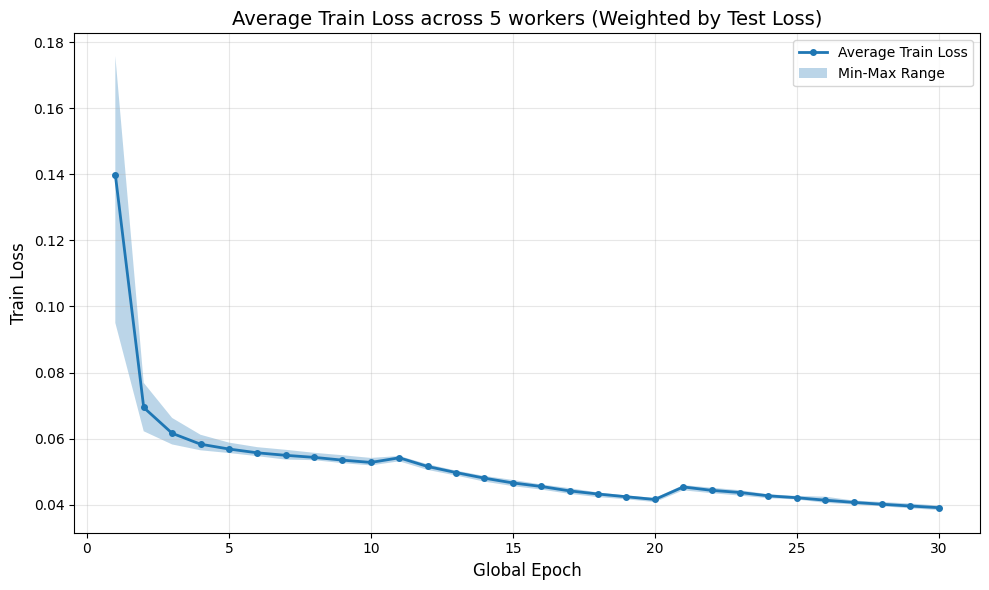

In [3]:
# Plot 1: Average Train Loss
if not all(np.isnan(v) for v in avg_train_loss):
    plt.figure(figsize=(10, 6))
    valid_x = [i+1 for i, v in enumerate(avg_train_loss) if not np.isnan(v)]
    valid_loss = [v for v in avg_train_loss if not np.isnan(v)]
    valid_min = [min_train_loss[i] for i, v in enumerate(avg_train_loss) if not np.isnan(v)]
    valid_max = [max_train_loss[i] for i, v in enumerate(avg_train_loss) if not np.isnan(v)]
    
    plt.plot(valid_x, valid_loss, marker="o", label="Average Train Loss", linewidth=2, markersize=4)
    plt.fill_between(valid_x, valid_min, valid_max, alpha=0.3, label="Min-Max Range")
    plt.xlabel("Global Epoch", fontsize=12)
    plt.ylabel("Train Loss", fontsize=12)
    plt.title(f"Average Train Loss across {num_workers} workers (Weighted by Test Loss)", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()
else:
    print("Warning: No valid train loss data to plot!")


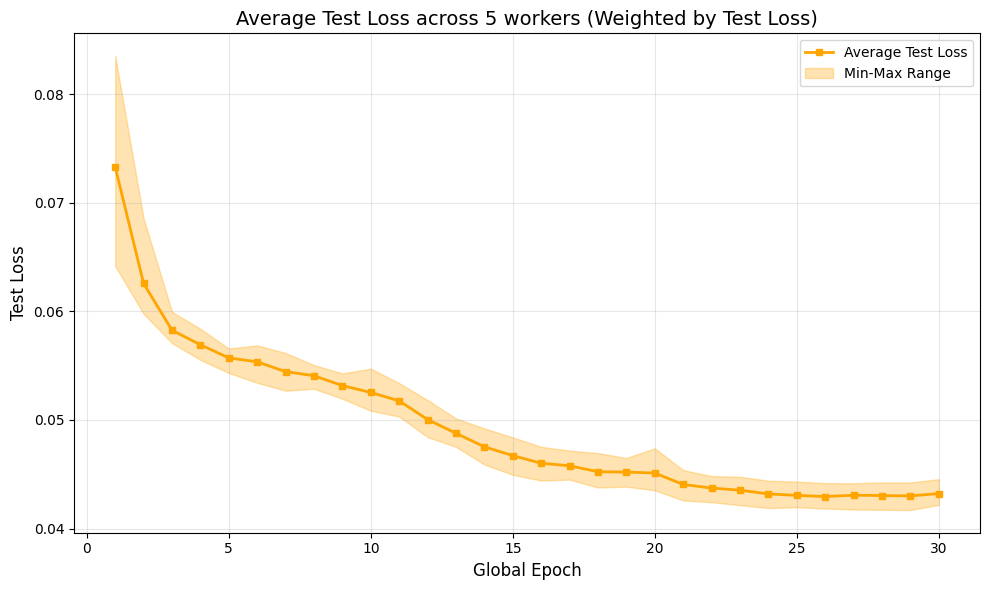

In [4]:
# Plot 2: Average Test Loss
if not all(np.isnan(v) for v in avg_test_loss):
    plt.figure(figsize=(10, 6))
    valid_x = [i+1 for i, v in enumerate(avg_test_loss) if not np.isnan(v)]
    valid_loss = [v for v in avg_test_loss if not np.isnan(v)]
    valid_min = [min_test_loss[i] for i, v in enumerate(avg_test_loss) if not np.isnan(v)]
    valid_max = [max_test_loss[i] for i, v in enumerate(avg_test_loss) if not np.isnan(v)]
    
    plt.plot(valid_x, valid_loss, marker="s", label="Average Test Loss", linewidth=2, markersize=4, color="orange")
    plt.fill_between(valid_x, valid_min, valid_max, alpha=0.3, label="Min-Max Range", color="orange")
    plt.xlabel("Global Epoch", fontsize=12)
    plt.ylabel("Test Loss", fontsize=12)
    plt.title(f"Average Test Loss across {num_workers} workers (Weighted by Test Loss)", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()
else:
    print("Warning: No valid test loss data to plot!")


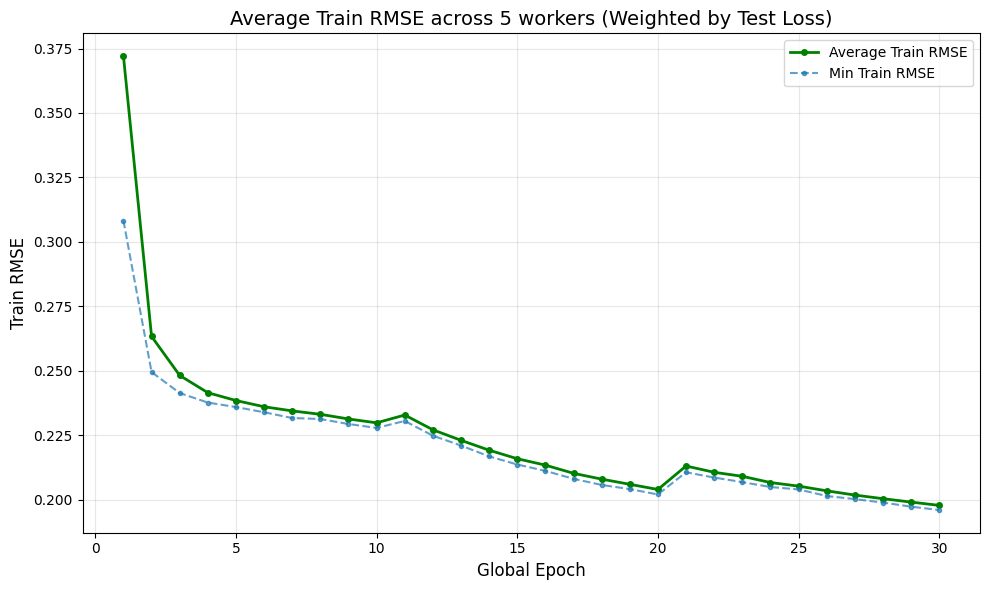

In [5]:
# Plot 3: Average Train RMSE
plt.figure(figsize=(10, 6))
plt.plot(x, avg_train_rmse, marker="o", label="Average Train RMSE", linewidth=2, markersize=4, color="green")
plt.plot(x, min_train_rmse, marker=".", label="Min Train RMSE", linestyle="--", alpha=0.7)
plt.xlabel("Global Epoch", fontsize=12)
plt.ylabel("Train RMSE", fontsize=12)
plt.title(f"Average Train RMSE across {num_workers} workers (Weighted by Test Loss)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


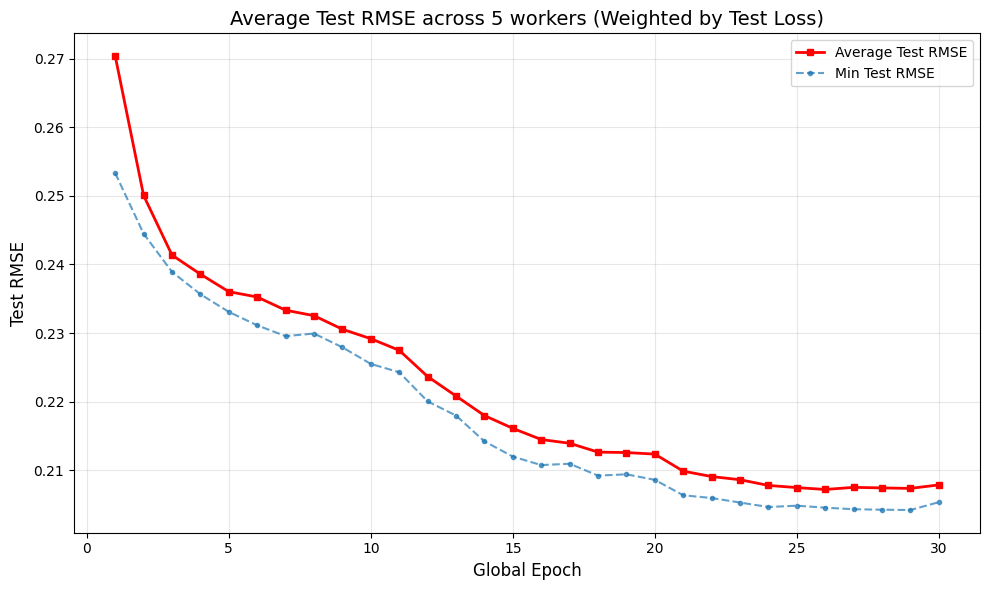

In [6]:
# Plot 4: Average Test RMSE
plt.figure(figsize=(10, 6))
plt.plot(x, avg_test_rmse, marker="s", label="Average Test RMSE", linewidth=2, markersize=4, color="red")
plt.plot(x, min_test_rmse, marker=".", label="Min Test RMSE", linestyle="--", alpha=0.7)
plt.xlabel("Global Epoch", fontsize=12)
plt.ylabel("Test RMSE", fontsize=12)
plt.title(f"Average Test RMSE across {num_workers} workers (Weighted by Test Loss)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


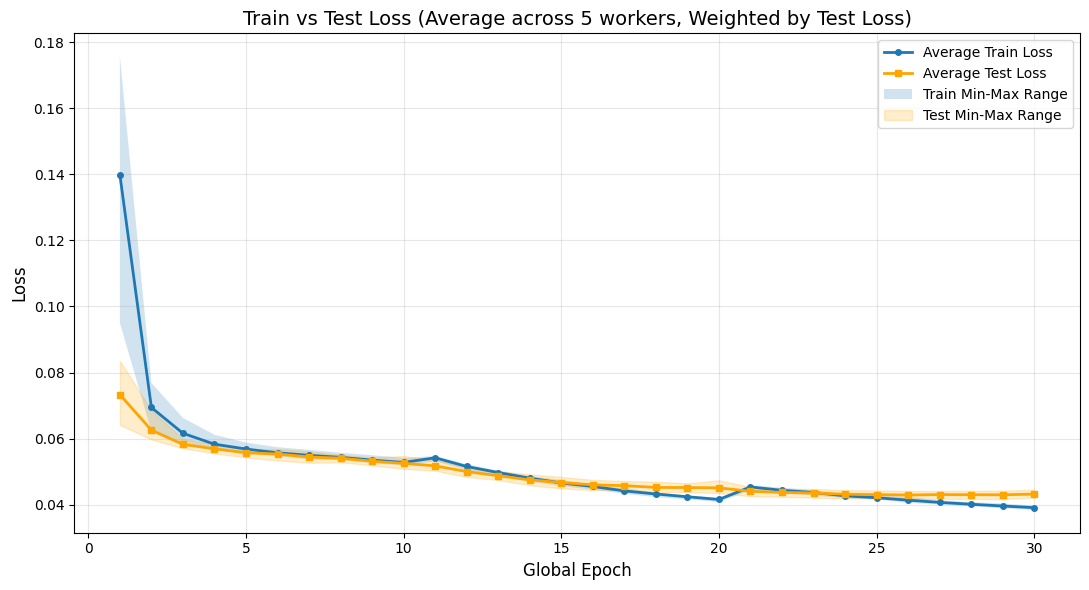

In [7]:
# Plot 5: Combined Train vs Test Loss
plt.figure(figsize=(11, 6))
plt.plot(x, avg_train_loss, marker="o", label="Average Train Loss", linewidth=2, markersize=4)
plt.plot(x, avg_test_loss, marker="s", label="Average Test Loss", linewidth=2, markersize=4, color="orange")
plt.fill_between(x, min_train_loss, max_train_loss, alpha=0.2, label="Train Min-Max Range")
plt.fill_between(x, min_test_loss, max_test_loss, alpha=0.2, label="Test Min-Max Range", color="orange")
plt.xlabel("Global Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title(f"Train vs Test Loss (Average across {num_workers} workers, Weighted by Test Loss)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


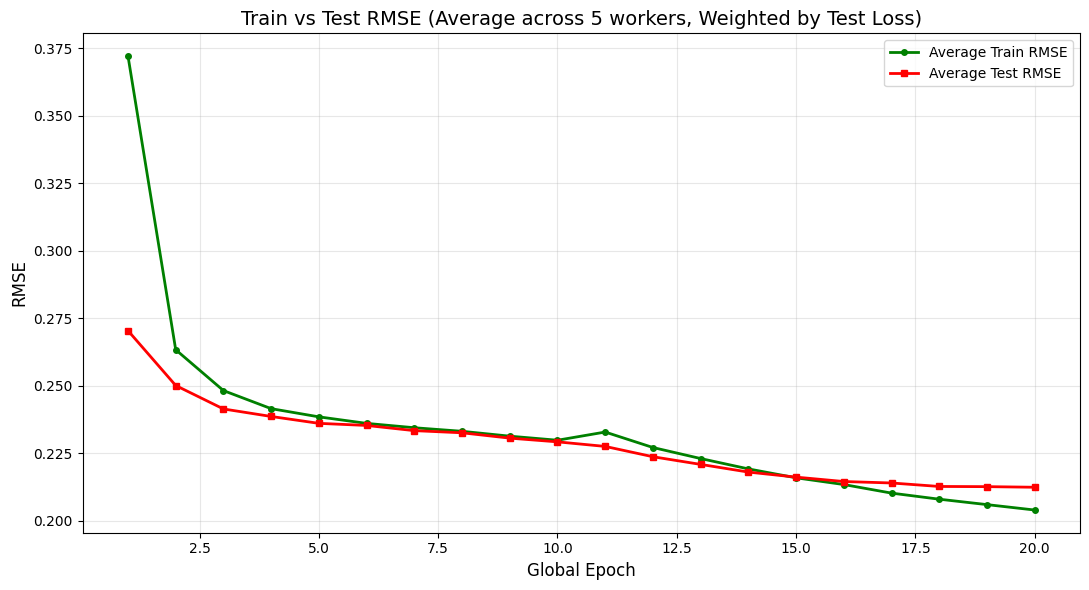

In [22]:
# Plot 6: Combined Train vs Test RMSE
plt.figure(figsize=(11, 6))
plt.plot(x, avg_train_rmse, marker="o", label="Average Train RMSE", linewidth=2, markersize=4, color="green")
plt.plot(x, avg_test_rmse, marker="s", label="Average Test RMSE", linewidth=2, markersize=4, color="red")
plt.xlabel("Global Epoch", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.title(f"Train vs Test RMSE (Average across {num_workers} workers, Weighted by Test Loss)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


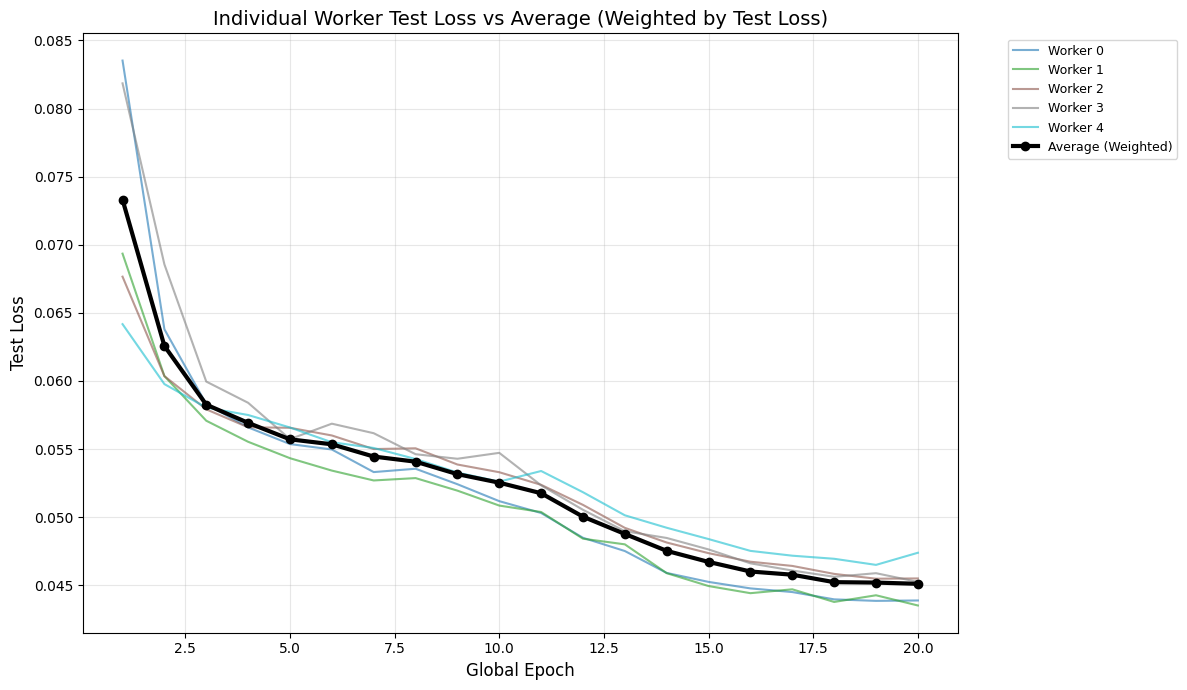

In [23]:
# Plot 7: Individual Worker Performance (Test Loss)
plt.figure(figsize=(12, 7))
colors = plt.cm.tab10(np.linspace(0, 1, num_workers))
for i, worker in enumerate(all_candidates):
    plt.plot(x[:len(worker["test_losses"])], worker["test_losses"], 
             label=f"Worker {i}", alpha=0.6, linewidth=1.5, color=colors[i])

plt.plot(x, avg_test_loss, marker="o", label="Average (Weighted)", linewidth=3, markersize=6, color="black")
plt.xlabel("Global Epoch", fontsize=12)
plt.ylabel("Test Loss", fontsize=12)
plt.title(f"Individual Worker Test Loss vs Average (Weighted by Test Loss)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()


In [24]:
# Print summary statistics
print("=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
print(f"\nFinal Epoch Results (Epoch {total_epochs}):")
print(f"  Average Train Loss: {avg_train_loss[-1]:.4f}")
print(f"  Average Test Loss:  {avg_test_loss[-1]:.4f}")
print(f"  Average Train RMSE: {avg_train_rmse[-1]:.4f}")
print(f"  Average Test RMSE:  {avg_test_rmse[-1]:.4f}")
print(f"\nBest Results (Minimum across all epochs):")
print(f"  Best Train Loss: {min(avg_train_loss):.4f} (Epoch {avg_train_loss.index(min(avg_train_loss)) + 1})")
print(f"  Best Test Loss:  {min(avg_test_loss):.4f} (Epoch {avg_test_loss.index(min(avg_test_loss)) + 1})")
print(f"  Best Train RMSE: {min(avg_train_rmse):.4f} (Epoch {avg_train_rmse.index(min(avg_train_rmse)) + 1})")
print(f"  Best Test RMSE:  {min(avg_test_rmse):.4f} (Epoch {avg_test_rmse.index(min(avg_test_rmse)) + 1})")
print("=" * 60)


SUMMARY STATISTICS

Final Epoch Results (Epoch 20):
  Average Train Loss: 0.0416
  Average Test Loss:  0.0451
  Average Train RMSE: 0.2039
  Average Test RMSE:  0.2124

Best Results (Minimum across all epochs):
  Best Train Loss: 0.0416 (Epoch 20)
  Best Test Loss:  0.0451 (Epoch 20)
  Best Train RMSE: 0.2039 (Epoch 20)
  Best Test RMSE:  0.2124 (Epoch 20)
